# MOLE DETECTION  -- Mole Type 7 Classes --

#### Import Necessary Libraries

In [20]:
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import time

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import TensorBoard

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import cv2

NAME="molemulticlass-{}".format(int(time.time())) # log file name for tensorboard

#### Constants

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}
labels = {
    0: 'Actinic keratoses (akiec)',
    1: 'Basal cell carcinoma (bcc)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Melanocytic nevi (nv)',
    6: 'Vascular lesions (vasc)',
}
int_label_mapping = dict((value, key) for key, value in label_mapping.items())

SIZE=32  # image size

#### Read the data

In [3]:

data = pd.read_csv('data/HAM10000_metadata.csv')

labele = LabelEncoder()
labele.fit(data['dx'])
data['label'] = labele.transform(data["dx"]) 

print(list(labele.classes_))



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


### Class weights or resampling

In [72]:
#Class Weights- this is first option for unbalanced data- did not use it
y=data['label']
class_weights = dict(zip(np.unique(y), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y), 
                y=y))) 

class_weights


{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [73]:
#resampling- second option for unbalanced data- did not use it
n_samples=500


from sklearn.utils import resample
print(data['label'].value_counts())

# Balancing the data
# tried balancing with class weights and imageprocessing best results came with randomoversampling


df_0 = data[data['label'] == 0]
df_1 = data[data['label'] == 1]
df_2 = data[data['label'] == 2]
df_3 = data[data['label'] == 3]
df_4 = data[data['label'] == 4]
df_5 = data[data['label'] == 5]
df_6 = data[data['label'] == 6]


df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
data_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

print(data_balanced['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


### Removing hair from mole images

In [4]:
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"

In [6]:
hair_images=data['path']

In [5]:
def shave_the_mole(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(3,3))
    blackhat = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, kernel)
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    shaved_mole = cv2.inpaint(image,threshold,5,cv2.INPAINT_TELEA)
    return shaved_mole

In [7]:

features_list=[]
for i,image_name in enumerate(hair_images[0:10015]):
    image = cv2.imread(hair_images[i])
    image_resize = cv2.resize(image,(SIZE,SIZE))
    final_image = shave_the_mole(image_resize)
    final_image=cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    features_list.append(final_image)
    
data['image']=features_list  

### Random over Sampling

In [9]:
ros = RandomOverSampler()
x=data
y=data['label']
data,y=ros.fit_resample(x, y)

In [10]:
data['label'].value_counts()

2    6705
5    6705
3    6705
4    6705
6    6705
1    6705
0    6705
Name: label, dtype: int64

In [96]:
#Use the path to read images. No need moles are shaved- use it if you dont shave the moles
#data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))



## Create Model 

In [11]:
#Convert dataframe column of image data to array

X = np.asarray(data['image'].tolist())
X = X/255. 
Y=data['label']  #
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical 



In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

### Clean the memory

In [16]:
import gc
import pandas as pd

del [[data,features_list,hair_images]]
gc.collect()
data=pd.DataFrame()
#df_2=pd.DataFrame()


### Create Model

In [13]:

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

#### Defigning callbacks and fitting the model

In [27]:

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
tensorboard=TensorBoard(log_dir='./logs/{}'.format(NAME)) ## logs are under logs folder for tensorboard
                            
batch_size = 16 
epochs = 50

learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

history = model.fit(x_train, y_train, validation_split=0.2, batch_size = batch_size,  epochs = epochs,callbacks = [learning_rate, early_stop, tensorboard])



Epoch 1/50
1878/1878 [==============================] - 40s 21ms/step - loss: 0.3094 - acc: 0.8853 - val_loss: 0.1956 - val_acc: 0.9369 - lr: 1.0000e-05
Epoch 2/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.3049 - acc: 0.8882 - val_loss: 0.1952 - val_acc: 0.9375 - lr: 1.0000e-05
Epoch 3/50
1878/1878 [==============================] - 38s 20ms/step - loss: 0.3063 - acc: 0.8858 - val_loss: 0.1952 - val_acc: 0.9372 - lr: 1.0000e-05
Epoch 4/50
1878/1878 [==============================] - 38s 20ms/step - loss: 0.3018 - acc: 0.8886 - val_loss: 0.1937 - val_acc: 0.9368 - lr: 1.0000e-05
Epoch 5/50
1878/1878 [==============================] - 39s 21ms/step - loss: 0.3068 - acc: 0.8860 - val_loss: 0.1937 - val_acc: 0.9377 - lr: 1.0000e-05
Epoch 6/50
1878/1878 [==============================] - 40s 21ms/step - loss: 0.3086 - acc: 0.8847 - val_loss: 0.1939 - val_acc: 0.9364 - lr: 1.0000e-05
Epoch 7/50
1875/1878 [============================>.] - ETA: 0s - loss: 0.3111 - a

up is from the third fitting

#### Evaluating Model

294/294 [==============================] - 3s 9ms/step - loss: 0.2033 - acc: 0.9320
Accuracy: 0.9320336580276489


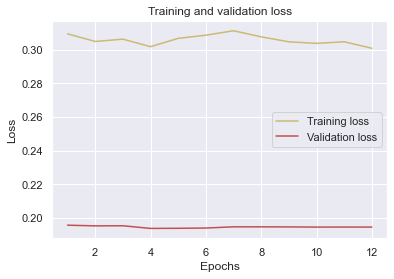

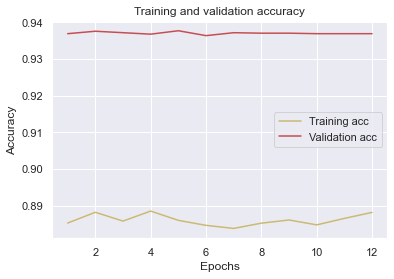

In [30]:
score = model.evaluate(x_test, y_test)
print('Accuracy:', score[1])


#Plot the training and validation accuracy and loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Calssification report and Confusion matrix

294/294 [==============================] - 2s 5ms/step
[[1295    0    0    0    0    0    0]
 [   1 1318    4    0    0    0    0]
 [   9   25 1268    2   22   25    0]
 [   0    0    0 1392    0    0    0]
 [  10    5   77    0 1168   52    0]
 [  12   48  144   11  183  940    8]
 [   0    0    0    0    0    0 1368]]
                                     precision    recall  f1-score   support

          Actinic keratoses (akiec)       0.98      1.00      0.99      1295
         Basal cell carcinoma (bcc)       0.94      1.00      0.97      1323
Benign keratosis-like lesions (bkl)       0.85      0.94      0.89      1351
                Dermatofibroma (df)       0.99      1.00      1.00      1392
                     Melanoma (mel)       0.85      0.89      0.87      1312
              Melanocytic nevi (nv)       0.92      0.70      0.80      1346
            Vascular lesions (vasc)       0.99      1.00      1.00      1368

                           accuracy                         

<AxesSubplot:>

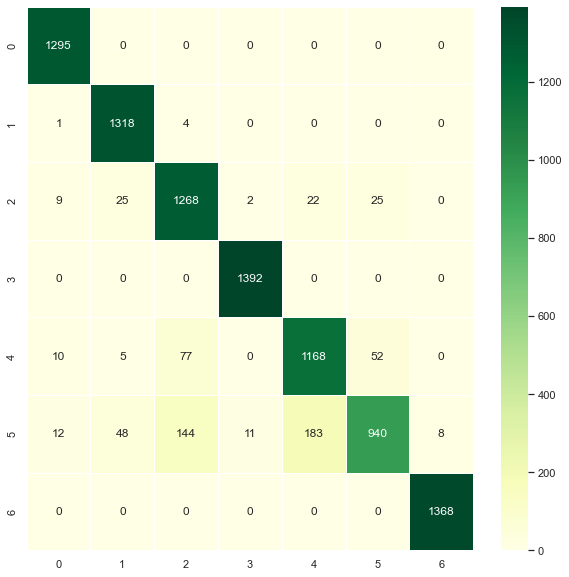

In [37]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)
#Print classification_report
print(classification_report(y_true, y_pred_classes,target_names=labels.values()))
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax,fmt='g',cmap="YlGn")



Text(0, 0.5, 'Percent of incorrect predictions')

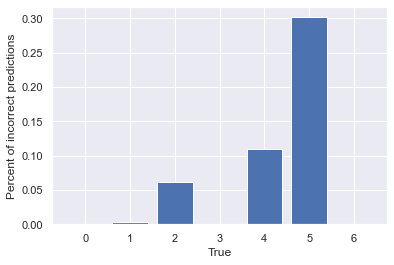

In [39]:
#Incorrect classifications
incorr = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr)
plt.xlabel('True')
plt.ylabel('Percent of incorrect predictions')

### Save the model and weights

In [26]:
model_json = model.to_json()
with open("modelmk.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelmk.h5")

----------